# Setup

In [5]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Optional

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from scipy.ndimage import gaussian_filter1d
from tqdm.notebook import tqdm, trange

%matplotlib inline

# Loading Steinmetz dataset

In [6]:
#Data retrieval
import os, requests

fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
    if not os.path.isfile(fname[j]):
        try:
            r = requests.get(url[j])
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fname[j], "wb") as fid:
                    fid.write(r.content)


In [7]:
#Data loading

all_data = []
for j in trange(len(fname)):
    all_data.extend(np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat'])

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  




In [8]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

# Explore data structure

In [9]:
# number of sessions in all_data
len(all_data)

39

In [10]:
# keys in each session
all_data[0].keys()

# what I need for now are 'mouse_name', 'date_exp', 'spks', 'brain_area', 'spks_passive, and (maybe) 'stim_onset'.


dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])

In [11]:
# shape of 'spks' : neurons x trials x time bins.
all_data[7]['spks'].shape

(1156, 250, 250)

In [12]:
# shape of 'spks_passive' : neurons x trials x time bins.
all_data[7]['spks_passive'].shape

(1156, 110, 250)

# Data we are going to use

In [13]:
# triplet brain projections we can use: out of 39 sessions, we can make use of 4.

triple_nets = [['LGd', 'VISp', 'VISa'], ['LGd', 'VISp', 'VISam'], ['LGd', 'VISp', 'VISl'], #Dorsal, Dorsal, Ventral Stream
               ['DG', 'CA3', 'CA1'], ['CA3', 'CA1', 'SUB'], ['CA2', 'CA1', 'SUB'], #HPC
               ['CP', 'GPe', 'SNr'], ['CP', 'SNr', 'VAL'], ['SNr', 'VAL', 'MOp'], # feedback loop projections 
               ['VAL', 'MOp', 'CP'], ['VAL', 'MOs', 'CP'],['VAL', 'MOs', 'SNr']] #Corticostriatal projections

usable_triplets = []

for i in range(len(all_data)):
    data = all_data[i]
    session = i
    name = data['mouse_name']
    date = data['date_exp']
    unique_area = np.unique(data['brain_area'])
    num_neurons = data['spks'].shape[0]
    num_trials = data['spks'].shape[1]

    for j in range(len(triple_nets)):
        if all([triple_nets[j][x] in unique_area for x in range(3)]):
            usable_triplets.append([session, name, date, triple_nets[j]]) # session number, mouse_name, date_exp, triple_nets (brain regions)

usable_triplets

[[3, 'Forssmann', '2017-11-01', ['LGd', 'VISp', 'VISa']],
 [7, 'Hench', '2017-06-15', ['DG', 'CA3', 'CA1']],
 [7, 'Hench', '2017-06-15', ['CA3', 'CA1', 'SUB']],
 [11, 'Lederberg', '2017-12-05', ['LGd', 'VISp', 'VISam']],
 [19, 'Moniz', '2017-05-16', ['LGd', 'VISp', 'VISa']]]

# Generate three brain area dataset 

In [14]:
def make_datasets(session, area1_name, area2_name, area3_name, cut_40=False, add_passive=False, smoothing=False, sigma=3):

    '''
    make a dataset triplet.
    session: session number.
    area1_name, area2_name, area3_name: three brain areas from low to high hierarchy.
    cut_40: True if you want to include time bins 50-90 only.
    add_passive: True if you want to include the passive data.
    smoothing: True if you want to apply gaussian filter to your data.
    sigma: gaussian filter sd. 3 to 5 is recommended. 
    '''

    area1 = []
    area2 = []
    area3 = []

    mini_data = all_data[session]

    for i in range(len(mini_data['brain_area'])):
    
        list_mapping = {area1_name: area1, area2_name: area2, area3_name: area3}
        area_name = mini_data['brain_area'][i]

        if area_name in list_mapping.keys():
            area_list = list_mapping[area_name]
            data_keys = ['spks']

            if add_passive:
                data_keys.append('spks_passive')

            if np.vstack([mini_data[data_key][i] for data_key in data_keys]).mean() < 0.01:
                continue
            
            items = []    
            for data_key in data_keys:
                item = mini_data[data_key][i].astype(np.float32)

                if smoothing:
                    item = gaussian_filter1d(item, sigma)
                    
                if cut_40:
                    item = item[:, 50:90]

                items.append(item)
            
            items = np.vstack(items)
            area_list.append(items)

    return np.array(area1), np.array(area2), np.array(area3)

In [15]:
# run this to set up three brain areas you are interested in
area1, area2, area3 = make_datasets(11, 'LGd', 'VISp', 'VISam', smoothing=True, sigma=3)
print('area1', area1.shape, 'area2:', area2.shape, 'area3:', area3.shape)

area1 (8, 340, 250) area2: (21, 340, 250) area3: (42, 340, 250)


In [16]:
# reshape the data in order to use PyTorch.
area1_ = area1.transpose(1, 0, 2)
area2_ = area2.transpose(1, 0, 2)
area3_ = area3.transpose(1, 0, 2)

# make sure shapes of the data are the same. Here, shape[0] is the number of trials. 
assert area1_.shape[0] == area2_.shape[0] == area3_.shape[0]

indices = np.arange(area1_.shape[0])

np.random.seed(42)
np.random.shuffle(indices)

area1_ = area1_[indices, :, :]
area2_ = area2_[indices, :, :]
area3_ = area3_[indices, :, :]

train_len = area1_.shape[0] * 4 // 5

X = torch.from_numpy(area1_)
Y = torch.from_numpy(area2_)
Z = torch.from_numpy(area3_)

device = "cuda" if torch.cuda.is_available() else "cpu"
X = X.to(device)
Y = Y.to(device)
Z = Z.to(device)

# separate train and validation set 
X_train = X[:train_len]
Y_train = Y[:train_len]
Z_train = Z[:train_len]

X_valid = X[train_len:]
Y_valid = Y[train_len:]
Z_valid = Z[train_len:]



# Create Model Class

## 1) Convolutional FF model (we ended up not using this)

In [17]:
class ConvModel(nn.Module):
    def __init__(self, input_neurons, output_neurons, num_layers=8, kernel_size=64, hidden_channels=128):
        super().__init__()
        self.in_conv = nn.Conv1d(input_neurons, hidden_channels, 1)
        
        self.convolutions = nn.ModuleList([nn.Sequential(
            nn.ConstantPad1d(padding=(kernel_size - 1, 0), value=0),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size)
        ) for _ in range(num_layers)])
        
        self.out_conv = nn.Conv1d(hidden_channels, output_neurons, 1)
        
        
    def forward(self, x):
        x = self.in_conv(x).relu()
        
        for layer in self.convolutions:
            x = x + layer(x).relu()
            
        x = self.out_conv(x)
        return x

## 2) Unet model 

In [19]:
class UNetModel(nn.Module):
    def __init__(self, input_neurons, output_neurons, layers_per_block=3, num_blocks=4, kernel_size=16, hidden_channels=4):
        super().__init__()
        self.in_padding = nn.ConstantPad1d(padding=(3, 3), value=0)  # 250 -> 256
        self.in_conv = nn.Conv1d(input_neurons, hidden_channels, 1)
        
        self.downsamplers = nn.ModuleList([
            nn.Sequential(
                *[
                    nn.Conv1d(hidden_channels * (2 ** (i - 1)), hidden_channels * (2 ** i), 1)
                    if i > 0 
                    else nn.Identity()
                ],
                *[
                    nn.Sequential(
                        nn.ConstantPad1d(padding=(kernel_size - 1, 0), value=0),
                        nn.Conv1d(hidden_channels * (2 ** i), hidden_channels * (2 ** i), kernel_size),
                        nn.ReLU()
                    )
                    for j in range(layers_per_block)
                ]
            )
            for i in range(num_blocks)
        ])
        
        self.residual_downsamplers = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(hidden_channels * (2 ** (i - 1)), hidden_channels * (2 ** i), 1),
                nn.AvgPool1d(2)
            )
            if i > 0
            else nn.Identity()
            for i in range(num_blocks)
        ])
        
        self.upsamplers = nn.ModuleList([
            nn.Sequential(
                *[
                    nn.Sequential(
                        nn.ConstantPad1d(padding=(kernel_size - 1, 0), value=0),
                        nn.Conv1d(hidden_channels * (2 ** i), hidden_channels * (2 ** i), kernel_size),
                        nn.ReLU()
                    )
                    for j in range(layers_per_block)
                ],
                *[
                    nn.Conv1d(hidden_channels * (2 ** i), hidden_channels * (2 ** (i - 1)), 1)
                    if i > 0
                    else nn.Identity()
                ]
            )
            for i in reversed(range(num_blocks))
        ])
        
        self.residual_upsamplers = nn.ModuleList([
            nn.Conv1d(hidden_channels * (2 ** i), hidden_channels * (2 ** (i - 1)), 1)
            if i > 0
            else nn.Identity()
            for i in reversed(range(num_blocks))
        ])
        
        self.out_conv = nn.Conv1d(hidden_channels, output_neurons, 1)
        
    def forward(self, x):
        x = self.forward_features(x)

        for upsampler, residual_upsampler in zip(self.upsamplers, self.residual_upsamplers):
            r = x
            x = x.repeat_interleave(2, dim=-1)
            x = upsampler(x)
            
            if r.shape[1] != r.shape[0]:
                r = residual_upsampler(r)      
                
            if r.shape[-1] * 2 == x.shape[-1]:
                r = r.repeat_interleave(2, dim=-1)
            
            x = x + r

        x = self.out_conv(x).relu()
        return x[:, :, 3:-3]  # 256 -> 250
    
    
    def forward_features(self, x):
        x = self.in_padding(x)
        x = self.in_conv(x).relu()
        
        for downsampler, residual_downsampler in zip(self.downsamplers, self.residual_downsamplers):
            r = x
            x = F.avg_pool1d(x, 2)
            x = downsampler(x)
            
            if r.shape[1] != x.shape[1]:
                assert r.shape[1] * 2 == x.shape[1]
                r = residual_downsampler(r)
                
            if r.shape[-1] == x.shape[-1] * 2:
                r = F.avg_pool1d(r, 2)
            
            x = x + r
            
        return x

## 3) Fulaly connected FF model 

In [244]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, timebins, in_neurons, out_neurons, hidden_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        
        self.timebins = timebins

        # Linear function 1: X_dim = [time bins x neurons] --> hidden_dim
        self.fc1 = nn.Linear(timebins * in_neurons, hidden_dim)
        
        # Linear function 2: hidden_dim --> Y_dim = [time bins x neurons] 
        self.fc2 = nn.Linear(hidden_dim, timebins * out_neurons)
    
    def forward(self, x):
        n_batch = x.shape[0]
        assert x.shape[-1] == self.timebins
        
        # Linear function 1
        out = self.fc1(x.reshape(n_batch, -1)).relu()
        # Linear function 2
        out = self.fc2(out).relu()

        return out.reshape(n_batch, -1, self.timebins)

# Train the Model (use GPU for this!) 

In [282]:
model1 = UNetModel(X.shape[1], Y.shape[1], hidden_channels=4).to(device)
model2 = UNetModel(Y.shape[1], Z.shape[1], hidden_channels=4).to(device)

In [283]:
print(f"model1 has {sum([np.prod(p.shape) for p in model1.parameters()]):,} parameters")
print(f"model2 has {sum([np.prod(p.shape) for p in model2.parameters()]):,} parameters")

model1 has 133,917 parameters
model2 has 134,074 parameters


In [285]:
# quick plotting and check
state = torch.load('./sessionshuffle2/session11-noshuffle/models-100000.pt', map_location=torch.device('cpu'))
weights_1 = model1.load_state_dict(state[0])
weights_2 = model2.load_state_dict(state[1])
out1 = model1(X_train)
out2 = model2(Y_train)

In [260]:
iter = 0
optimizer = torch.optim.Adam([*model1.parameters(), *model2.parameters()], lr=1e-4)

X = X.to(device)
Y = Y.to(device)
Z = Z.to(device)

In [261]:
with trange(20000) as loop:
    for epoch in loop:
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output
        out1 = model1(X)
        out2 = model2(Y)

        # compute the loss
        loss1 = F.mse_loss(out1, Y)
        loss2 = F.mse_loss(out2, Z)
                
        loss = loss1 + loss2

        # getting gradients wrt parameters
        loss.backward()

        loop.set_postfix(loss=loss.item(), loss1=loss1.item(), loss2=loss2.item())

        # updating parameters
        optimizer.step()

In [286]:
# Forward pass to get output
features1 = model1.forward_features(X)
features2 = model2.forward_features(Y)

torch.save([features1, features2], f"unet{model1.in_conv.out_channels * 8}-features.pt")

## Plot some stuff to inspect model outcomes

In [287]:
print('Y mean:', Y.cpu().detach().numpy().mean(), 'Z mean:', Z.cpu().detach().numpy().mean())

Y mean: 0.035151258 Z mean: 0.06388488


In [288]:
print('out1 mean:', (out1.cpu().detach().numpy()).mean(), 'out2 mean:', (out2.cpu().detach().numpy()).mean())

out1 mean: 0.022127798 out2 mean: 0.04464619


In [289]:
print('out1 sd:', (out1.cpu().detach().numpy()).std(), 'out2 sd:', (out2.cpu().detach().numpy()).std())

out1 sd: 0.056155637 out2 sd: 0.070529886


Text(0.5, 0.95, 'Trial 18')

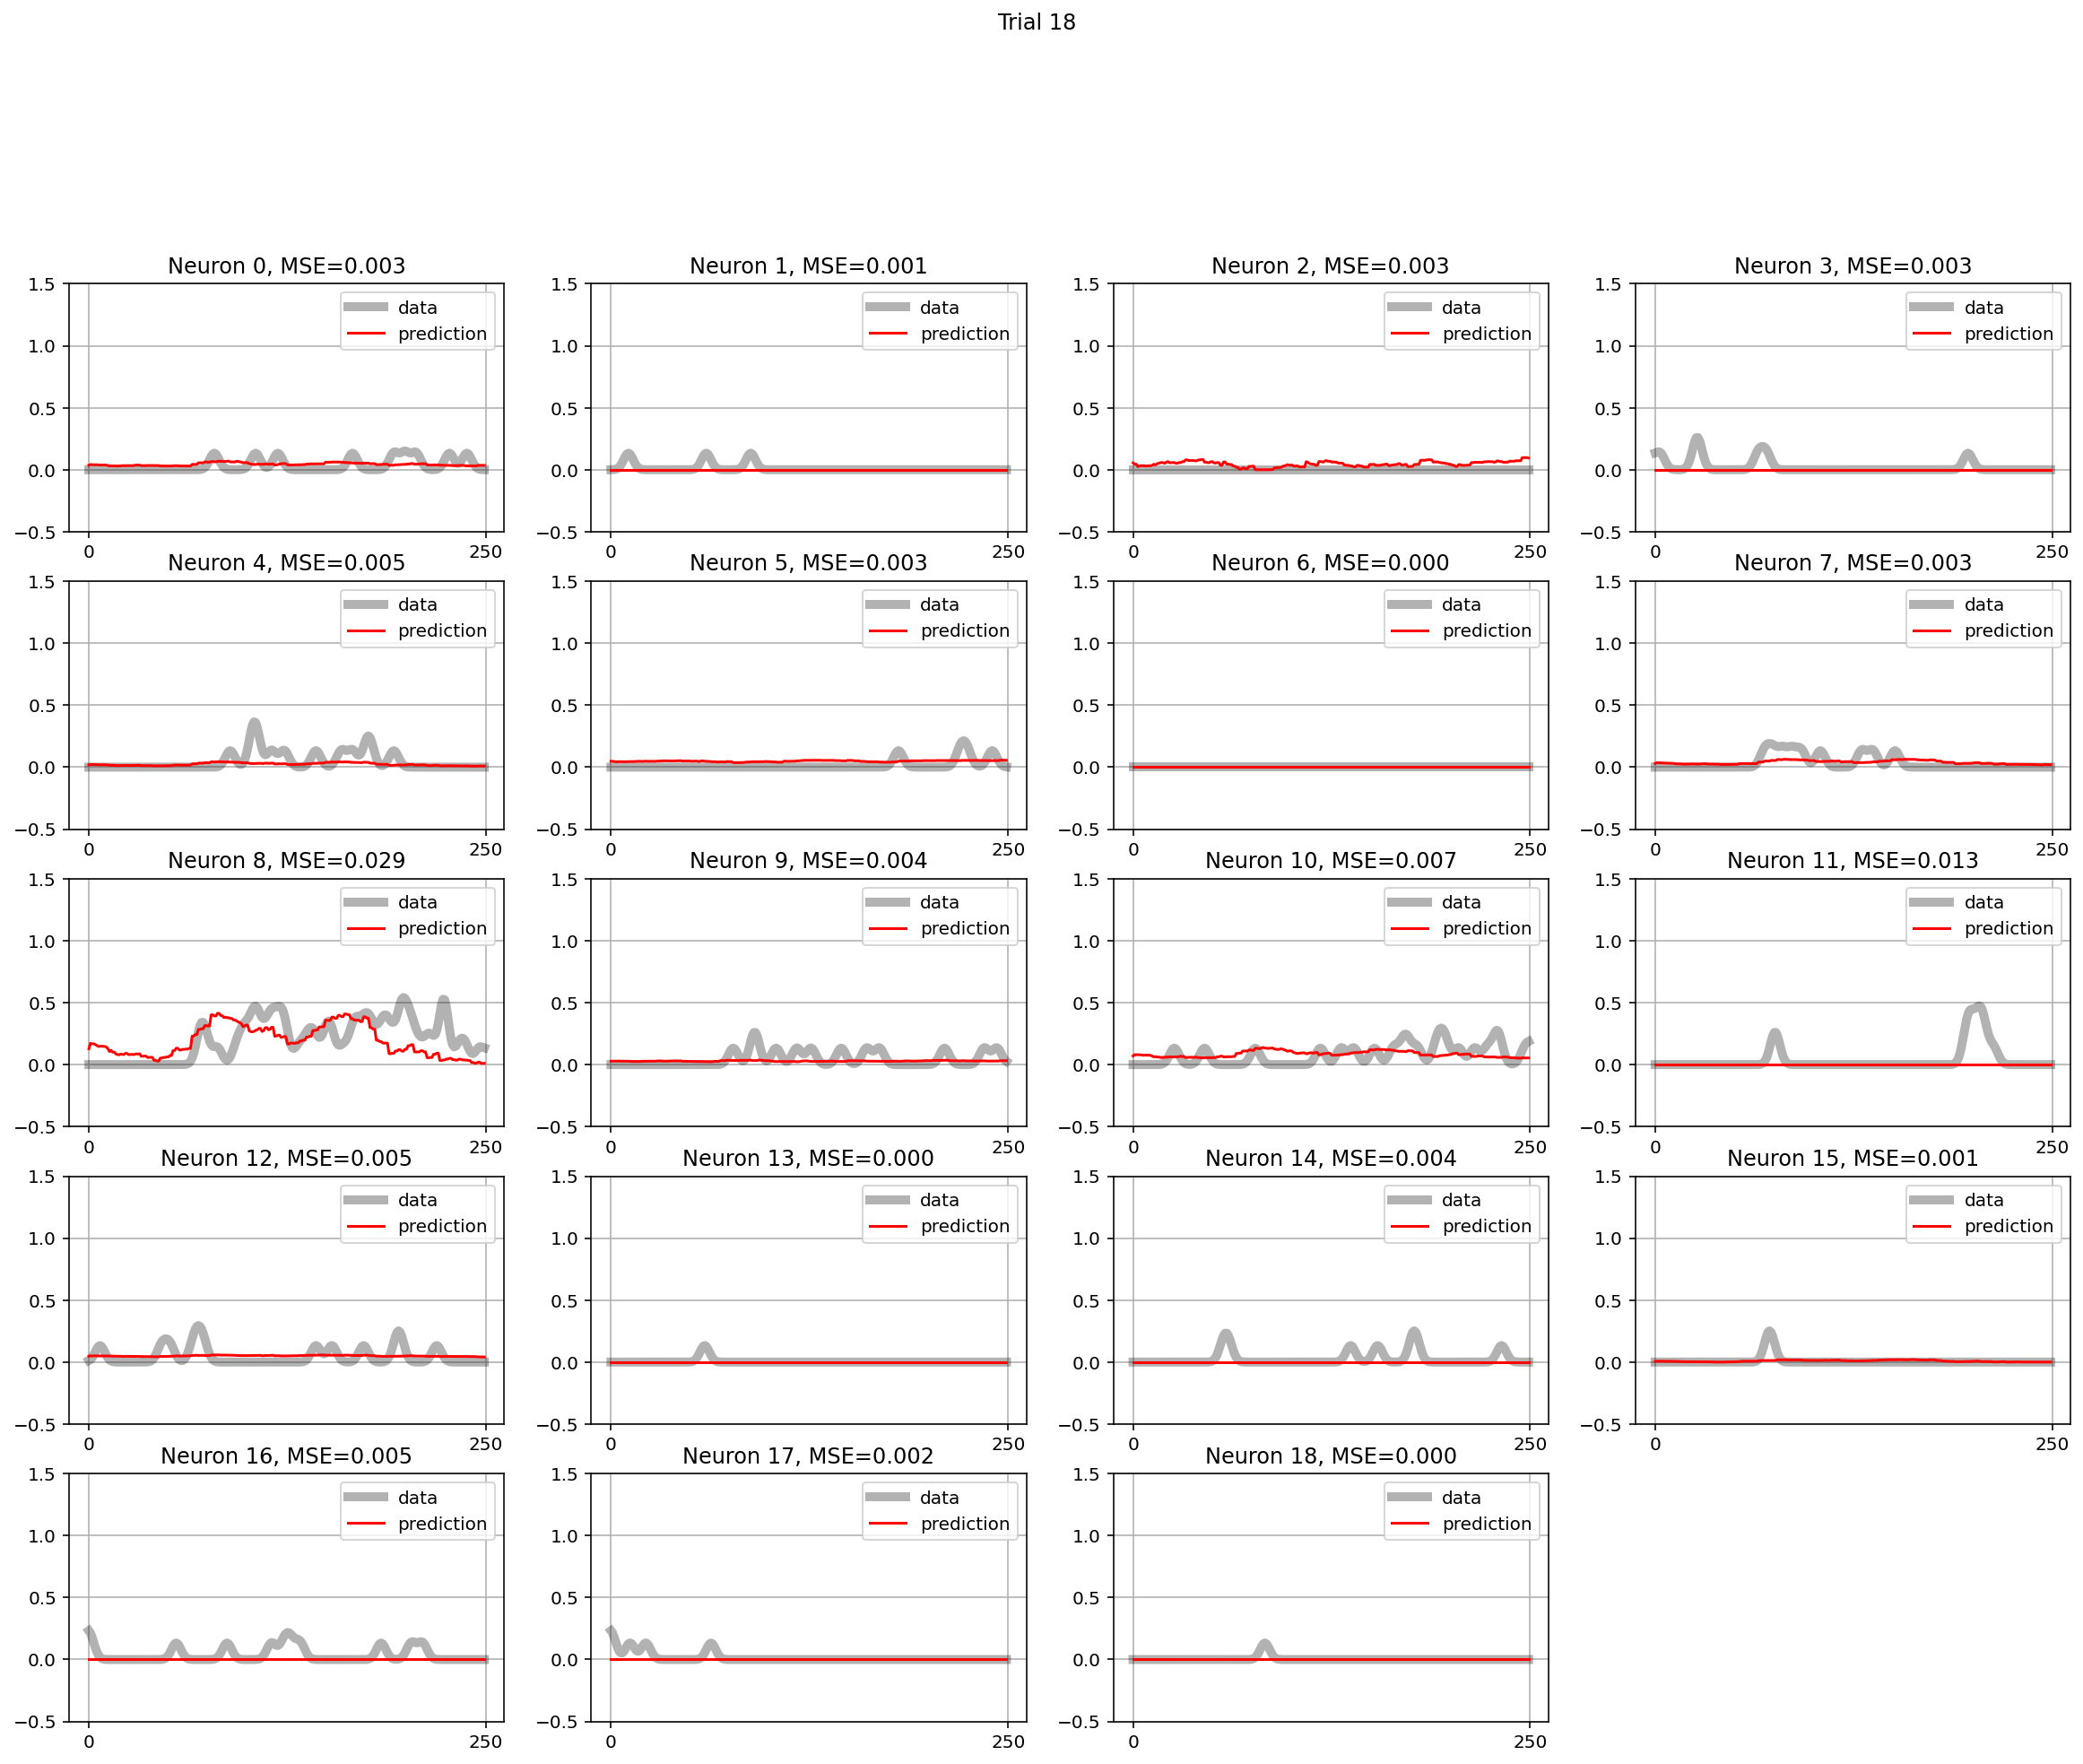

In [290]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

trial = 18
plt.figure(figsize=(20, 30))
for i in range(19):
    plt.subplot(10, 4, i+1)
    data = Z_valid[trial, i, :]
    prediction = out2[trial, i, :]
    plt.plot(data.detach().cpu().numpy(), label="data", linewidth=5, alpha=0.3, color='k')
    plt.plot(prediction.detach().cpu().numpy(), label="prediction", color='r')
    
    plt.legend()
    plt.ylim([-0.5, 1.5])
    plt.title(f"Neuron {i}, MSE={F.mse_loss(data, prediction).item():.3f}")
    plt.xticks([0, 250])
    plt.grid()
    
plt.suptitle(f"Trial {trial}", y=0.95)